In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

2024-01-12 14:19:49.145424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 14:19:49.216623: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 14:19:50.492871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-01-12 14:19:50.492913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: de

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from Cardiac_Electrophysiology import *
# from Evaluation_Methods import * 
from Hybrid import *
from KoopmanDL import *
import sys 
sys.path.append("../utils") 
from Evaluation_plot import *

## Build Training Data

In [7]:
s = np.load('./data/s_sample.npy')
v = np.load('./data/v_sample.npy')

# Build the input tensor
DataModel = Cardiac_Electrophysiology_DataModel()
x1 = np.linspace(0,10,51)
t = np.linspace(0,10,50)
u_t = np.sin(t)
u_x_mesh = DataModel.dx(x1,x1)
u = u_t[:,np.newaxis,np.newaxis] * u_x_mesh[np.newaxis,:]

# Build v_xx
dlt_x = x1[1]-x1[0]
v_train_xx = np.zeros(np.shape(v))
v_train_xx[:,:,0] = (2 * v[:,:,1] - 2 * v[:,:,0])/dlt_x**2
for i in range(1, np.shape(v)[2]-1):
    v_train_xx[:,:,i] = (v[:,:,i-1] + v[:,:,i+1] - 2*v[:,:,i])/dlt_x**2
v_train_xx[:,:,-1] = (2 * v[:,:,-2] - 2 * v[:,:,-1])/dlt_x**2
# v_train_xx = v_train_xx[:,1:-1,1:-1]

# Build v_yy
dlt_y = x1[1]-x1[0]
v_train_yy = np.zeros(np.shape(v))
v_train_yy[:,:,0] = (2 * v[:,1,:] - 2 * v[:,0,:])/dlt_y**2
for i in range(1, np.shape(v)[1]-1):
    v_train_yy[:,i,:] = (v[:,i-1,:] + v[:,i+1,:] - 2*v[:,i,:])/dlt_y**2
v_train_yy[:,:,-1] = (2 * v[:,-2,:] - 2 * v[:,-1,:])/dlt_y**2
# v_train_yy = v_train_yy[:,1:-1,1:-1]

# Build v_data, s_data
v_train = v
s_train = s

# Build training data
v1 = np.reshape(v_train[2:,:,:],(-1, 1))
v0 = np.reshape(v_train[1:-1,:,:],(-1,1))
lacev_x0 = np.reshape(v_train_xx[1:-1,:,:],(-1,1))
lacev_y0 = np.reshape(v_train_yy[1:-1,:,:],(-1,1))

lace_data = np.concatenate((lacev_x0,lacev_y0),axis=1)

m1 = np.reshape(s_train[2:,0,:,:],(-1,1))
m0 = np.reshape(s_train[1:-1,0,:,:],(-1,1))
n1 = np.reshape(s_train[2:,1,:,:],(-1,1))
n0 = np.reshape(s_train[1:-1,1,:,:],(-1,1))
h1 = np.reshape(s_train[2:,2,:,:],(-1,1))
h0 = np.reshape(s_train[1:-1,2,:,:],(-1,1))

x_data = np.concatenate((v0,m0,n0,h0),axis=1)
y_data = np.concatenate((v1,m1,n1,h1),axis=1)
u_data = np.reshape(u[1:-1,:,:],(-1,1))

## Plot Training Process

In [8]:
# Plot training process
mu_history = np.load('./output/mu_history.npy')
err_history = np.load('./output/err_history.npy')

In [9]:
mu_history_list = []
for i in range(np.shape(mu_history)[1]):
    mu = np.reshape(mu_history[:,i,:], (1,-1))[0]
    mu_history_list.append(mu)

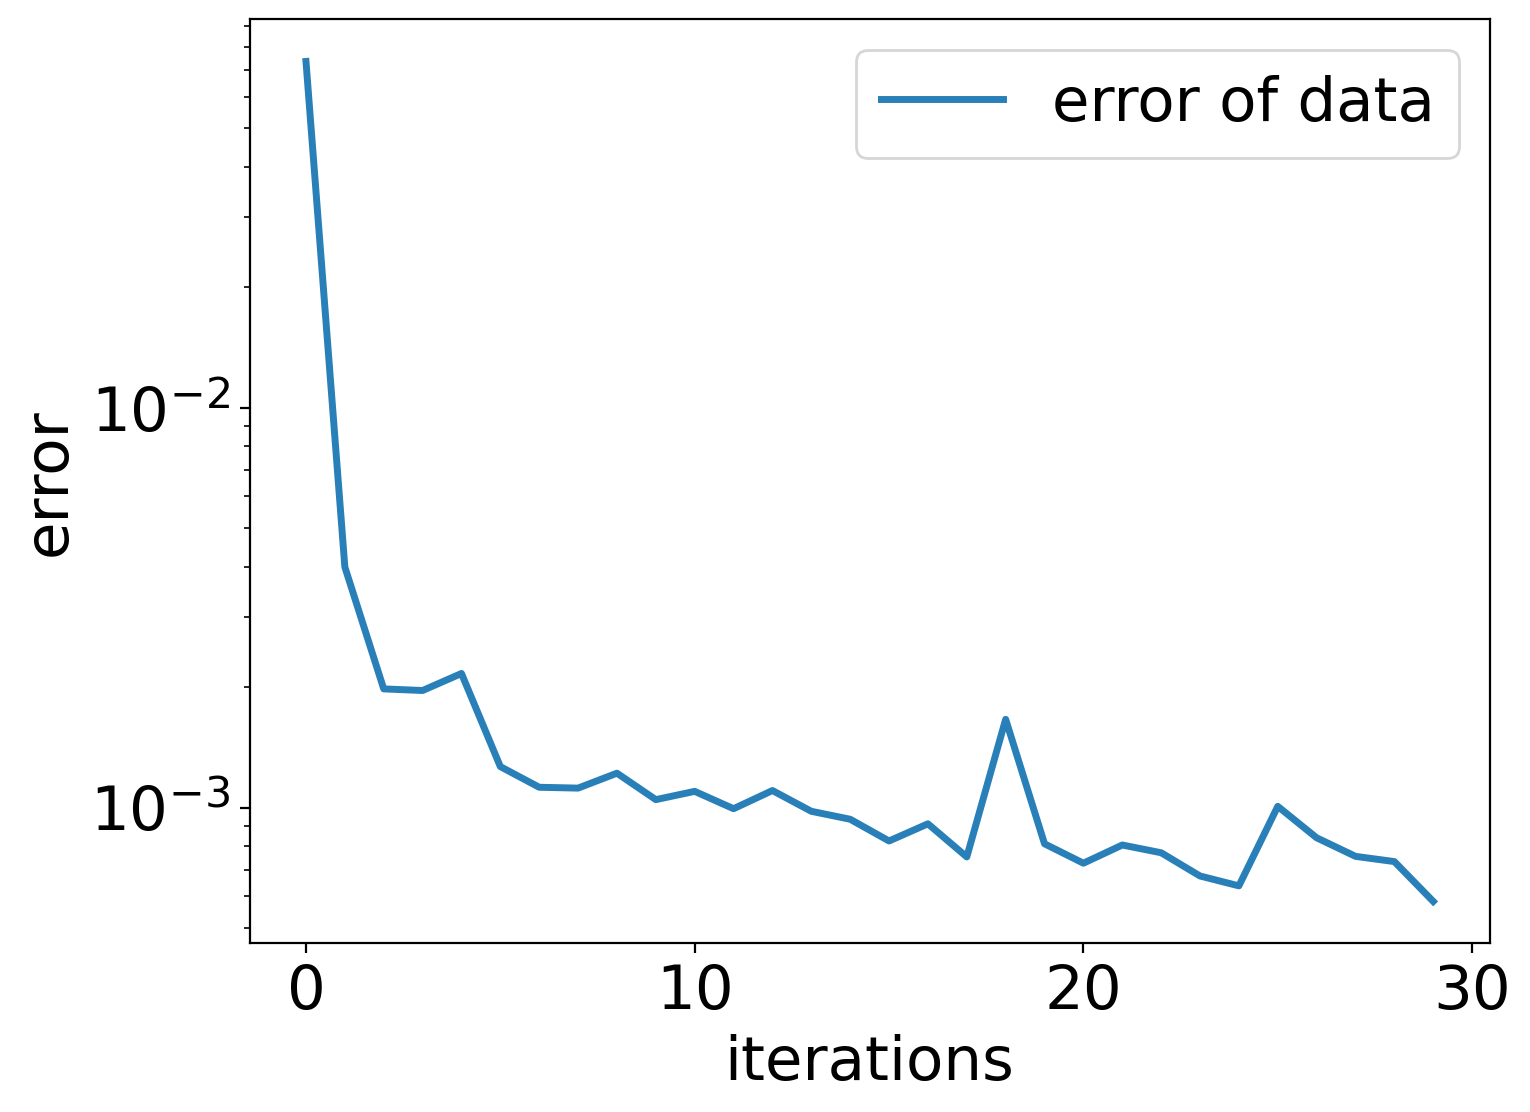

In [10]:
error_interate(err_history[:30], font_size = 22)

In [11]:
print(0.124* (t[1] - t[0]))

0.025306122448979593


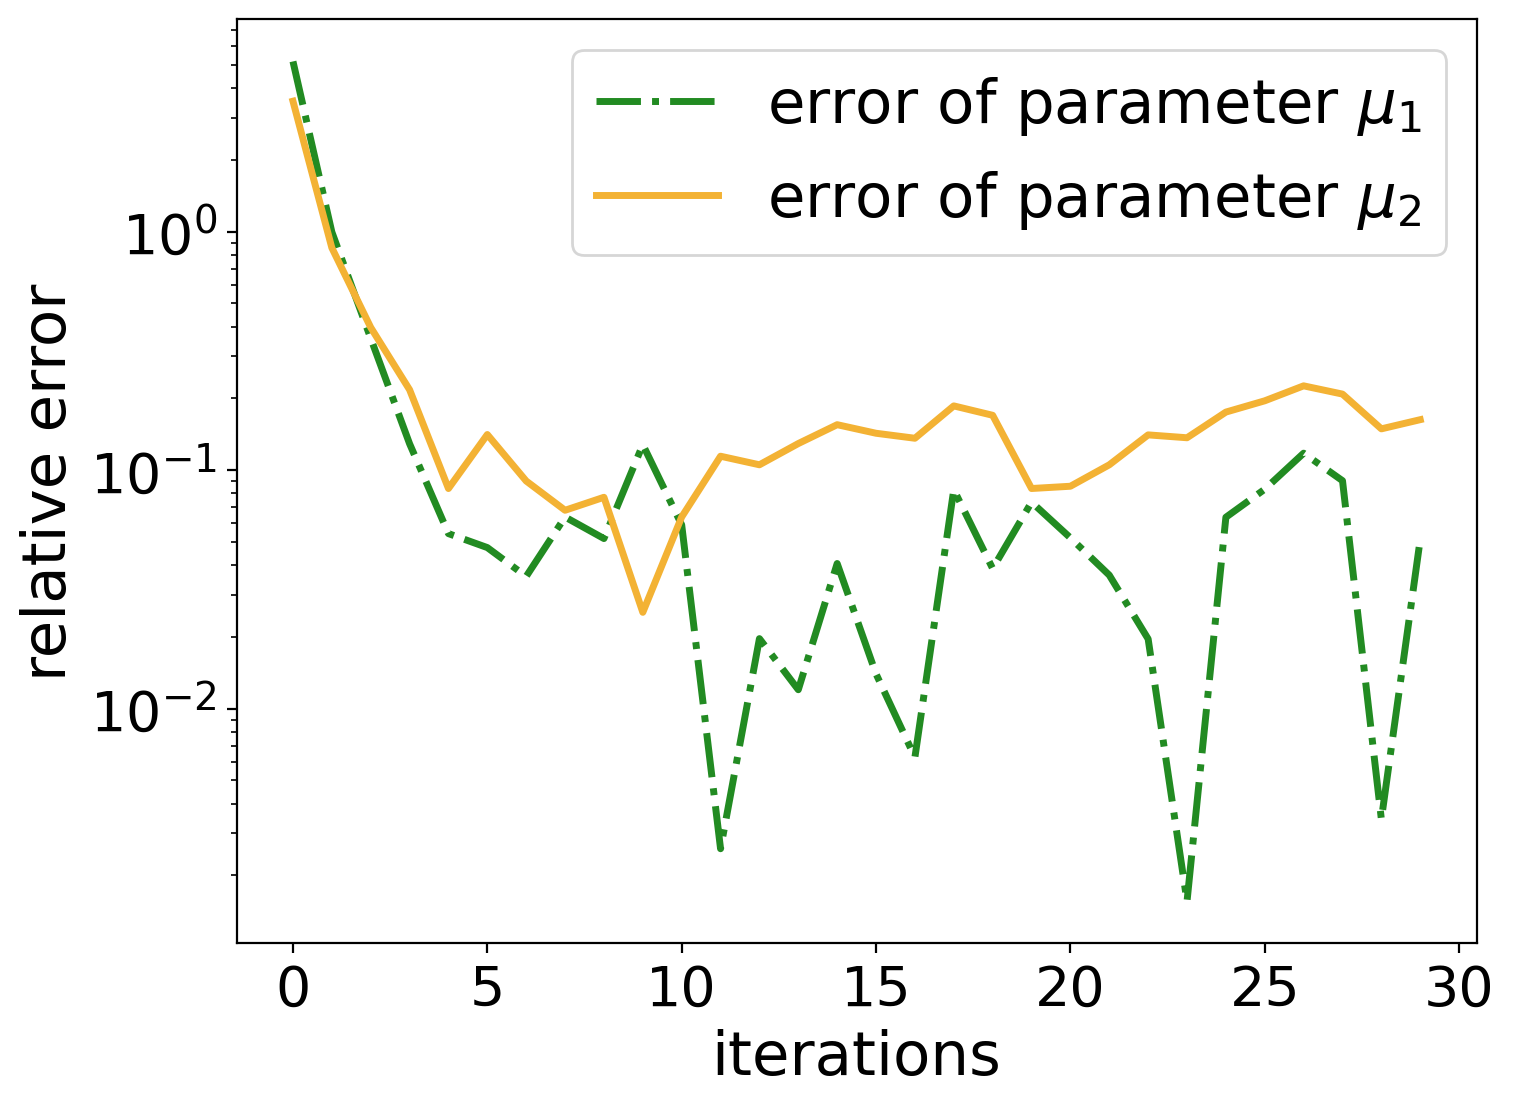

In [12]:
font_size = 22
line_width = 2.5
para_ref = 0.025306122448979593
plt.figure(dpi=100,figsize=(8,6))
para_ref_history = para_ref * np.ones(len(mu_history_list[1][:30]))
plt.plot(range(len(mu_history_list[1][:30])), np.abs(mu_history_list[1][:30] - para_ref_history)/para_ref, color = color_dict_compare['our'], linestyle = '-.', linewidth=line_width, label = 'error of parameter %s' % '$\mu_1$')
plt.plot(range(len(mu_history_list[2][:30])), np.abs(mu_history_list[2][:30] - para_ref_history)/para_ref, color = color_dict_compare['compare1'], linewidth=line_width, label = 'error of parameter %s' % '$\mu_2$')
plt.xlabel('iterations',fontsize=font_size)
plt.ylabel('relative error',fontsize=font_size)
plt.yscale('log')
plt.legend(fontsize=font_size)
plt.tick_params(labelsize=20)
plt.show()

In [13]:
# Linear Model
fusion_data = np.concatenate((np.reshape(x_data[:,0],(-1,1)),lace_data),axis = 1)

w, y_pred = Hybrid_compute_linear_weight(fusion_data, y_data[:,0])

In [14]:
err_relax = np.load('./output/err_history_acc.npy')
err_original = np.load('./output/err_history.npy')

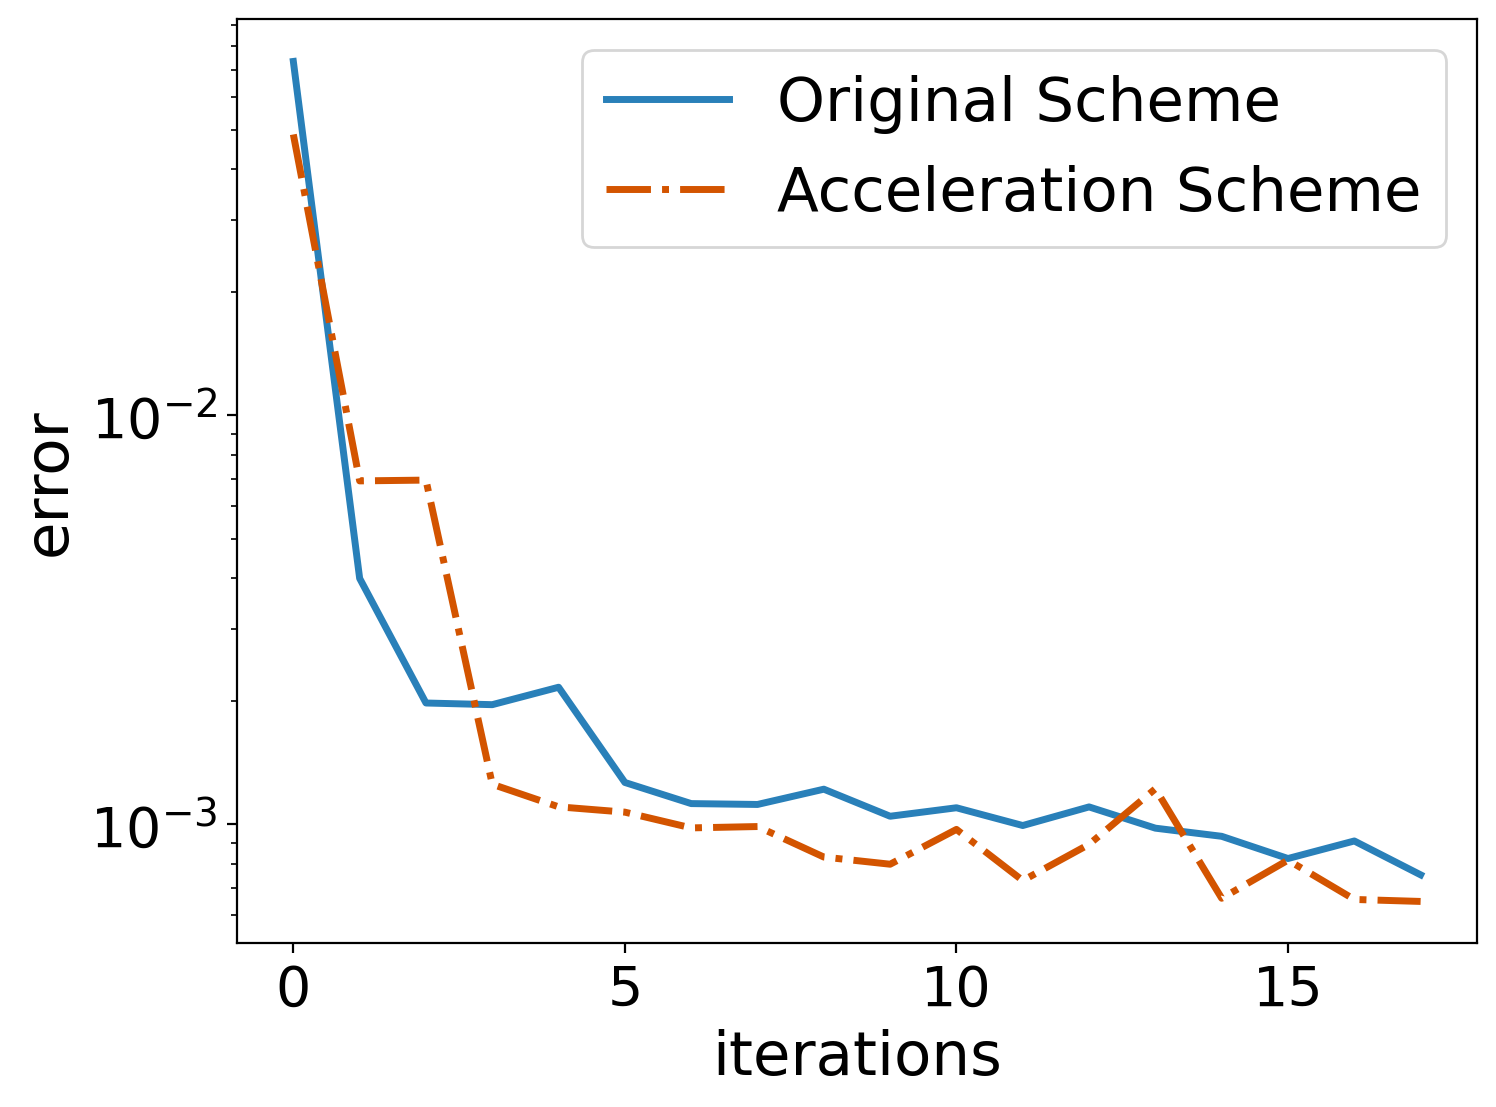

In [15]:
font_size = 22
line_width = 2.5

plt.figure(dpi=100,figsize=(8,6))
plt.plot(range(len(err_original[:18])), err_original[:18], linewidth = line_width, color = color_dict_single['error'], label = 'Original Scheme')
plt.plot(range(len(err_relax[:18])), err_relax[:18], linewidth = line_width,linestyle = '-.', color = color_dict_single['para'], label = 'Acceleration Scheme')


plt.xlabel('iterations', fontsize = font_size)
plt.ylabel('error',fontsize = font_size)
plt.yscale('log')
plt.legend(fontsize = font_size)
plt.tick_params(labelsize=20)
plt.show()

## Build Models
### Build Koopman Model

In [16]:
# Koopman Model
model_Koopman = KoopmanDL_Model(target_dim=4, u_dim=1,
                                  dic_trainable=KoopmanDL_DicNN, dic_layer_sizes=[64,64],
                                  operator_layer_sizes=[32,32])
model_Koopman.Build()
model_Koopman.model_KoopmanDL.load_weights('./koopman_checkpoints/ckpt')

2024-01-12 14:19:52.237340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Train Koopman
lr = 0.001
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model_Koopman.model_KoopmanDL.compile(optimizer=opt, loss='mse')

x_data_scaled = model_Koopman.Build_x_scaler(x_data)
y_data_scaled = model_Koopman.Build_y_scaler(y_data)
u_data_scaled = model_Koopman.Build_u_scaler(u_data)

print(np.shape(u_data_scaled))

(124848, 1)


### Hybrid Model

In [18]:
# Hybrid Model
model_Hybrid = Hybrid_Model(target_dim=4, u_dim=1,
                                  dic_trainable=KoopmanDL_DicNN, dic_layer_sizes=[64,64],
                                  operator_layer_sizes=[32,32])
model_Hybrid.Build_linear_para(mu_history[-1])
print(model_Hybrid.linear_para)
model_Hybrid.Build_koopman_model('./hybrid_checkpoints/ckpt',['./output/x_max.npy','./output/x_min.npy','./output/y_max.npy','./output/y_min.npy','./output/u_max.npy','./output/u_min.npy'])

[[1.01432001]
 [0.02312823]
 [0.01995995]]
[-60.75571078   0.19330318   1.           0.43696936]
[-2.16557769e+02 -3.82972066e-10  3.77271940e-01  6.33649802e-02]


### Residual Model

In [19]:
# Residual Model
mu_residual = np.load('./output/residual_w.npy')
model_residual = Hybrid_Model(target_dim=4, u_dim=1,
                                  dic_trainable=KoopmanDL_DicNN, dic_layer_sizes=[64,64],
                                  operator_layer_sizes=[32,32])
model_residual.Build_linear_para(mu_residual)
print(model_residual.linear_para)
model_residual.Build_koopman_model('./output/residual_learning_KoopmanModel.h5',['./output/residual_x_max.npy','./output/residual_x_min.npy','./output/residual_y_max.npy','./output/residual_y_min.npy','./output/residual_u_max.npy','./output/residual_u_min.npy'])

[[ 1.01130744]
 [-0.10546505]
 [-0.06378502]]
[-60.75571078   0.19330318   1.           0.43696936]
[-2.16557769e+02 -3.82972066e-10  3.77271940e-01  6.33649802e-02]


### Intrusively training Model

In [20]:
model_intrusive = Intrusive_combinde_model(target1_dim = 3, target2_dim = 4, u_dim=1,
                                  dic_trainable=KoopmanDL_DicNN, dic_layer_sizes=[64,64],
                                  operator_layer_sizes=[32,32])
model_intrusive.Build()
_, _, _, _ = model_intrusive.scale(x_data, y_data, fusion_data, u_data)
model_intrusive.combined_model.load_weights('intrusive_combined_model.h5')

## Prediction

In [21]:
# Build the input tensor
DataModel = Cardiac_Electrophysiology_DataModel()
x1 = np.linspace(0,10,51)
t = np.linspace(0,10,50)
u_t = np.sin(t)
u_x_mesh = DataModel.dx(x1,x1)
u = u_t[:,np.newaxis,np.newaxis] * u_x_mesh[np.newaxis,:]

# Build v_data, s_data
v0 = v[0,:,:]
s0 = s[0,:,:,:]

m0 = np.reshape(s0[0,:,:],(-1,1))
n0 = np.reshape(s0[1,:,:],(-1,1))
h0 = np.reshape(s0[2,:,:],(-1,1))


initial_data = np.concatenate((np.reshape(v0,(-1,1)), m0, n0, h0), axis = 1)

input_data = np.reshape(u,(np.shape(u)[0],-1))

In [22]:
steps = 25
dlt_x = x1[1]-x1[0]
dim = 51

In [23]:
v_ref = v[0:steps+1]
v_ref = np.reshape(v_ref, (np.shape(v_ref)[0], -1, 1))
s_ref = s[0:steps+1,:,:,:]

m_ref = np.reshape(s_ref[:,0,:,:],(np.shape(v_ref)[0],-1,1))
n_ref = np.reshape(s_ref[:,1,:,:],(np.shape(v_ref)[0],-1,1))
h_ref = np.reshape(s_ref[:,2,:,:],(np.shape(v_ref)[0],-1,1))

ref_data = np.concatenate((v_ref, m_ref, n_ref, h_ref), axis = 2)

In [24]:
predict_results = model_Hybrid.Long_time_predict(initial_data, steps, dlt_x, dim, input_data)

In [25]:
error = np.abs(ref_data - predict_results)
relative_error = error/np.abs(ref_data)

In [26]:
Koopman_predicts = model_Koopman.Long_time_predict(initial_data, steps, input_data)

In [27]:
error_koopman = np.abs(ref_data - Koopman_predicts)
relative_error_koopman = error_koopman/np.abs(ref_data)

In [28]:
Residual_predicts = model_residual.Long_time_predict(initial_data, steps, dlt_x, dim, input_data)

In [29]:
Intrusive_predicts = model_intrusive.long_time_predict(initial_data, steps, input_data, dlt_x)

(15, 50)


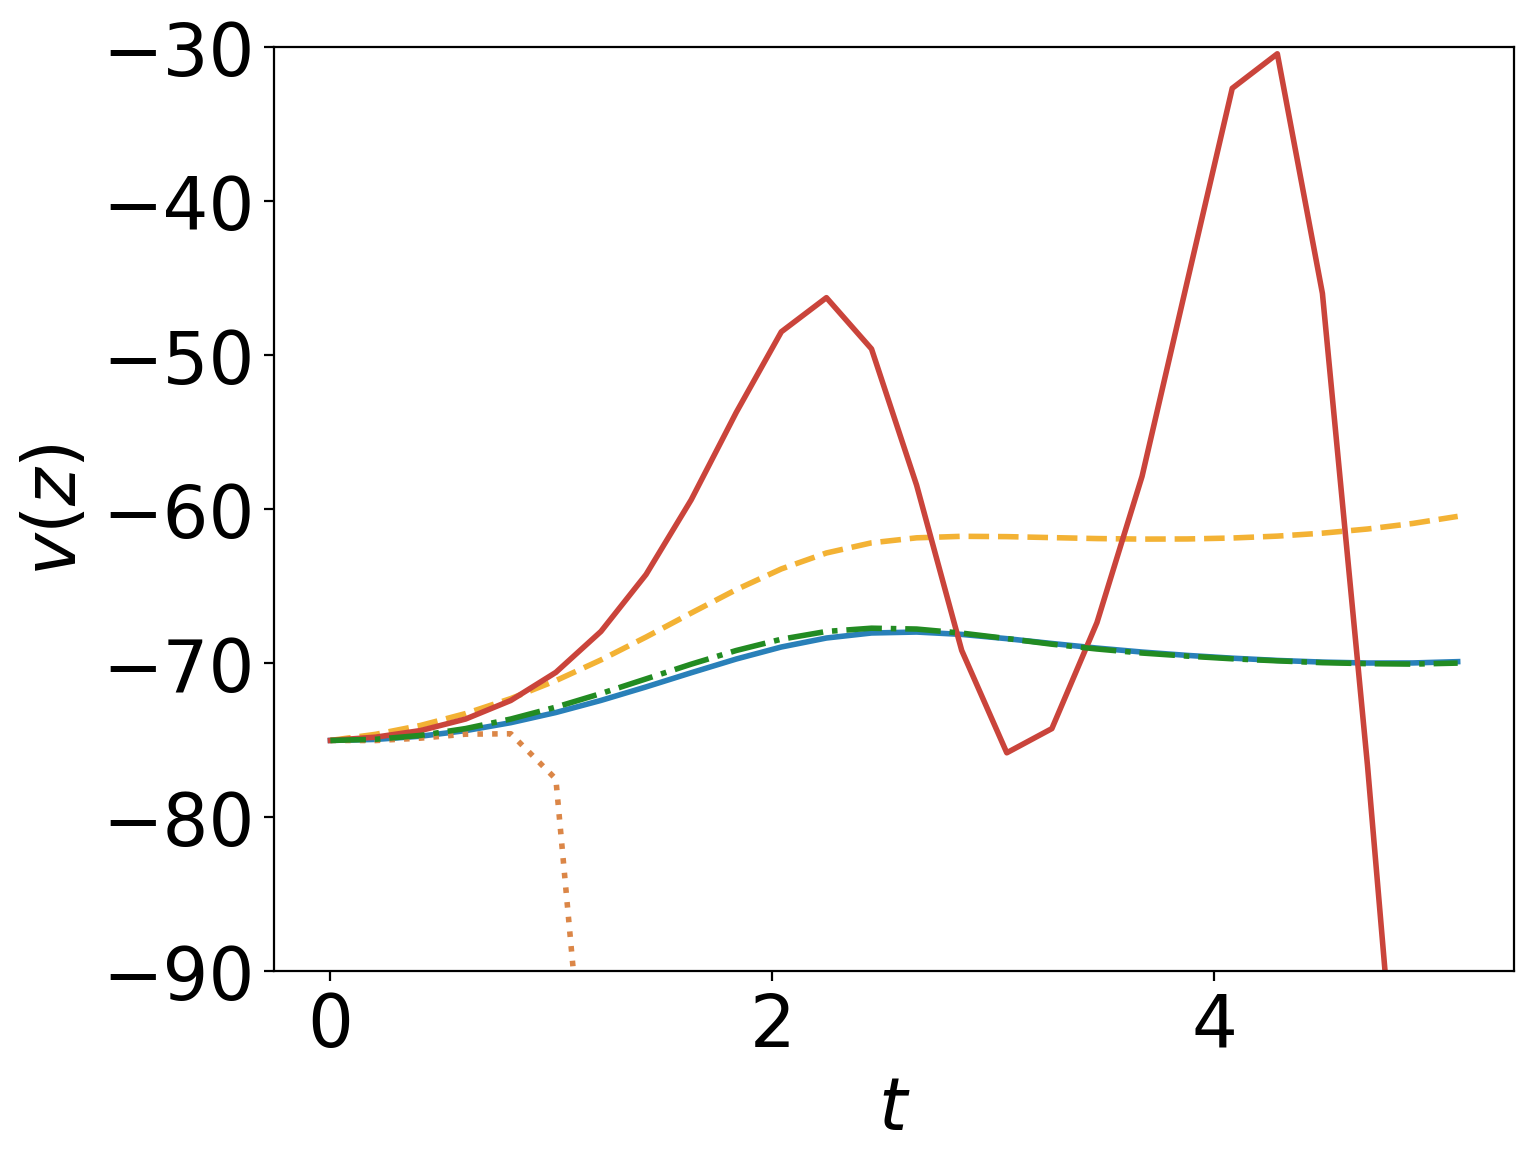

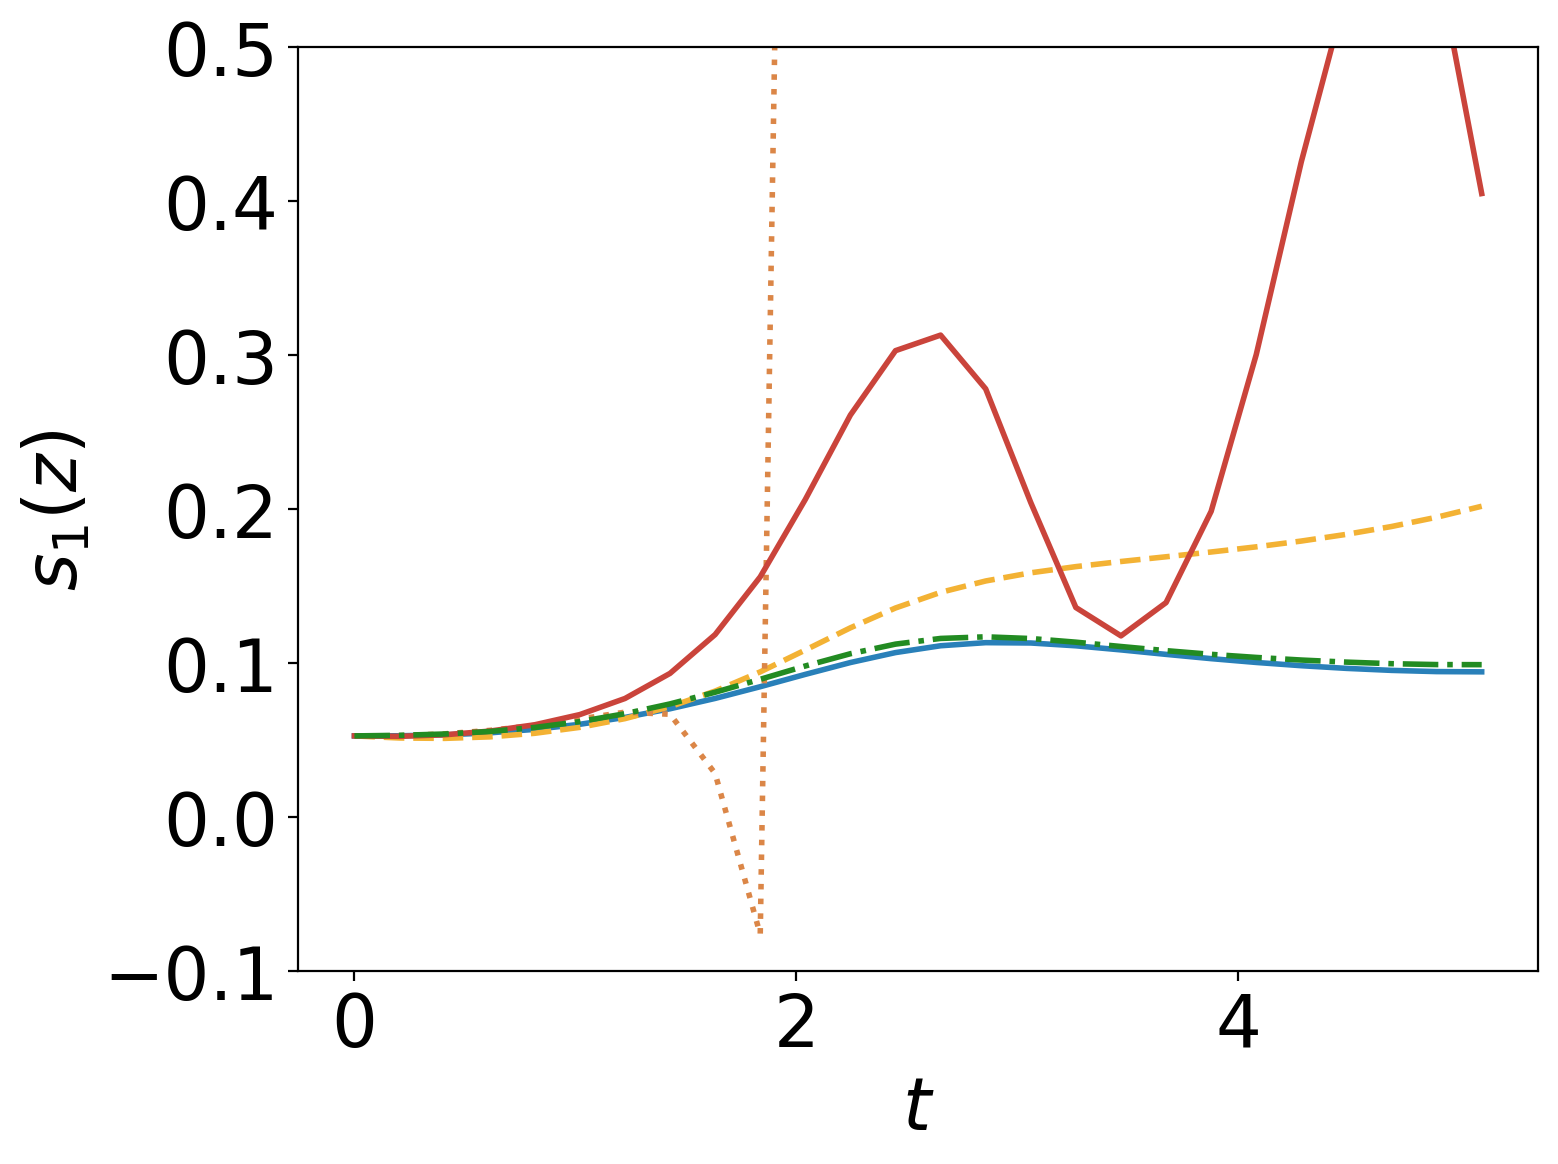

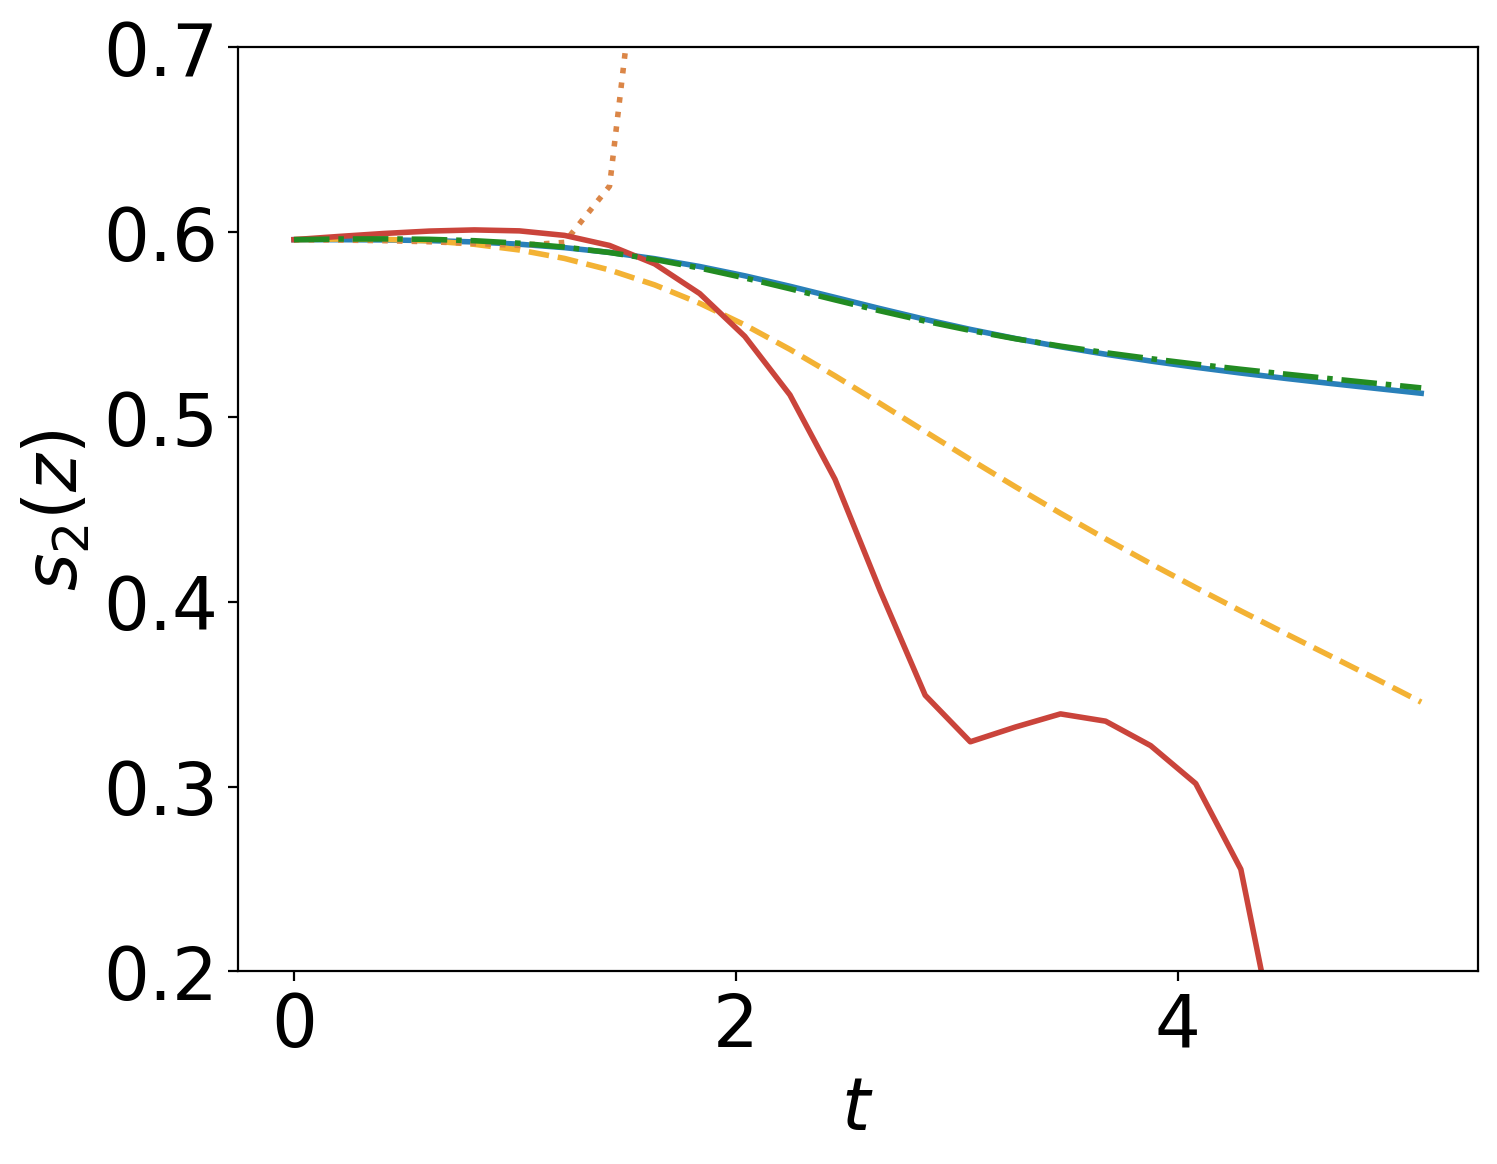

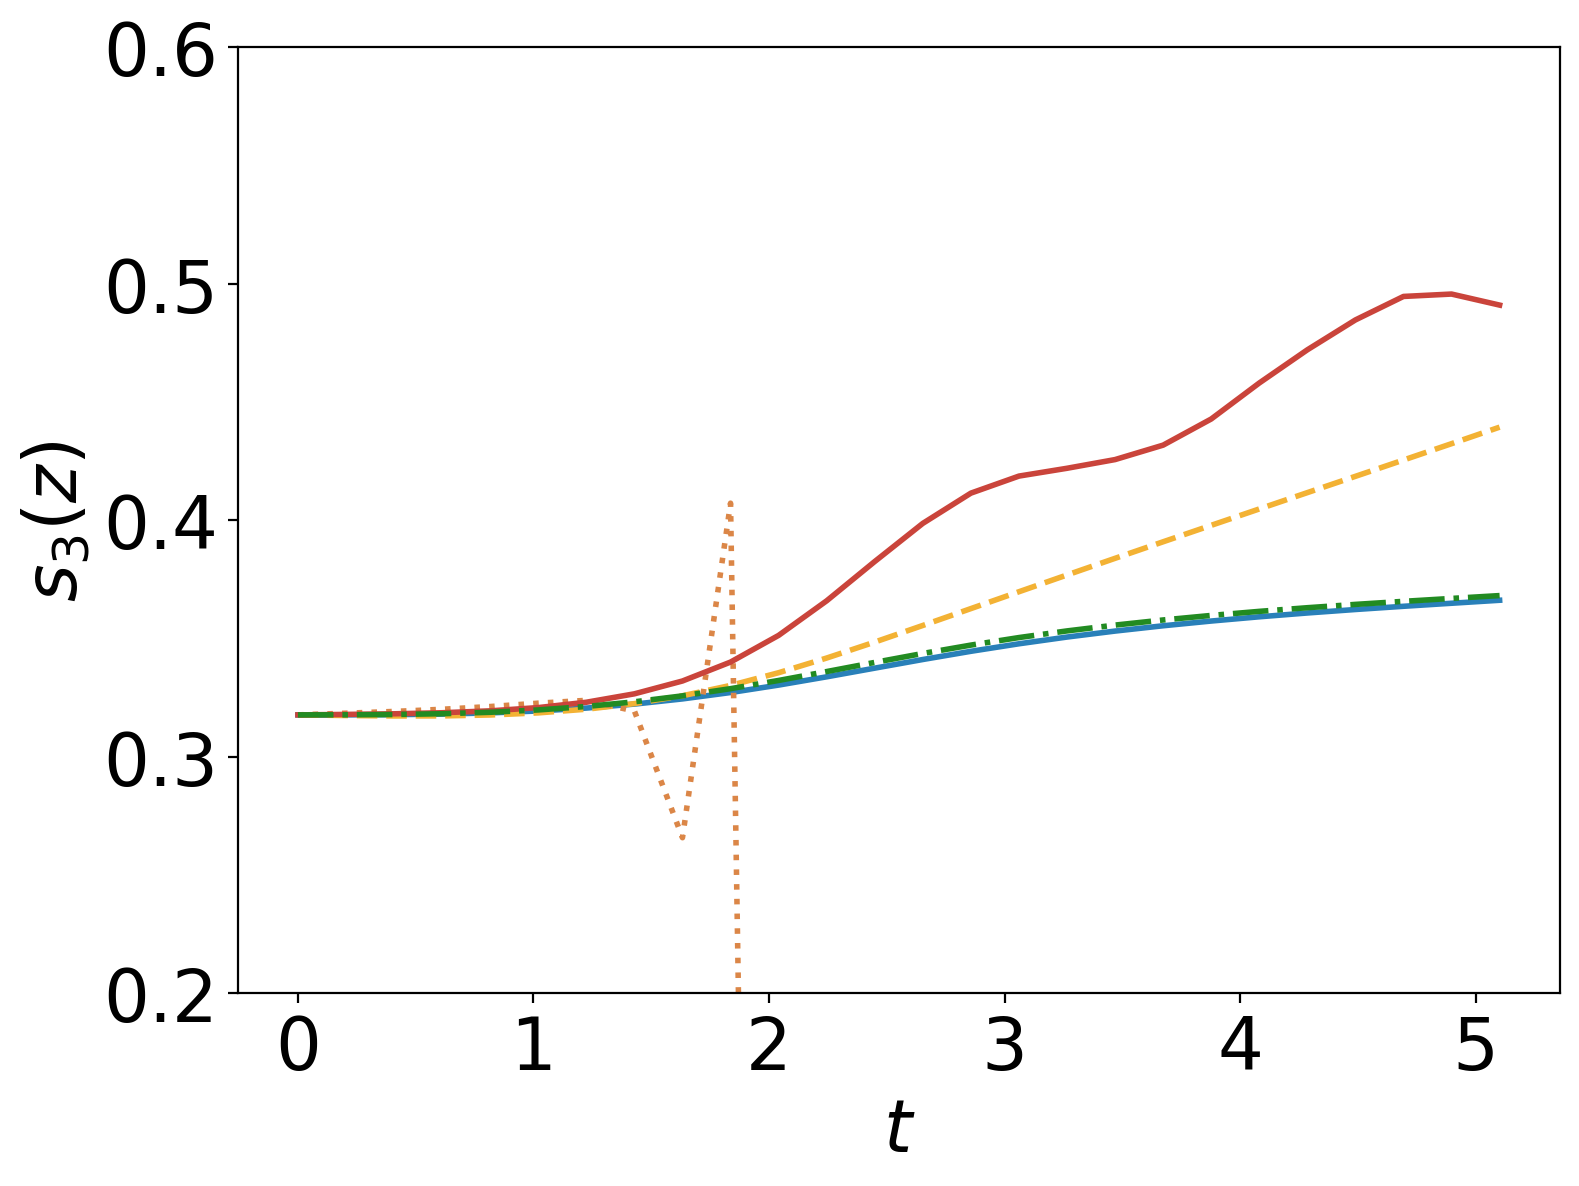

In [30]:
font_size = 26
line_width = 2.5
t_axis = t[:(steps+1)]

multi_step_hybrid_reshape = np.reshape(predict_results, (-1,51,51,4))
multi_step_koopman_reshape = np.reshape(Koopman_predicts, (-1,51,51,4))
multi_step_residual_reshape = np.reshape(Residual_predicts, (-1,51,51,4))
multi_step_intrusive_reshape = np.reshape(Intrusive_predicts, (-1,51,51,4))

multi_ref_reshape = np.reshape(ref_data, (-1,51,51,4))

# a_axis = np.random.randint(low = 0, high=51, size=None, dtype='l')
# b_axis = np.random.randint(low = 0, high=51, size=None, dtype='l')
a_axis, b_axis = 15,50
print((a_axis, b_axis))
line_width = 2

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,0],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,0], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')

plt.ylim(-90, -30)
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$v(z)$',fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,1],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,1], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_1(z)$',fontsize=font_size)
plt.ylim(-0.1, 0.5)

plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,2],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,2], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_2(z)$',fontsize=font_size)
plt.ylim(0.2, 0.7)

plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,3],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,3], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_3(z)$',fontsize=font_size)
plt.ylim(0.2, 0.6)
plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

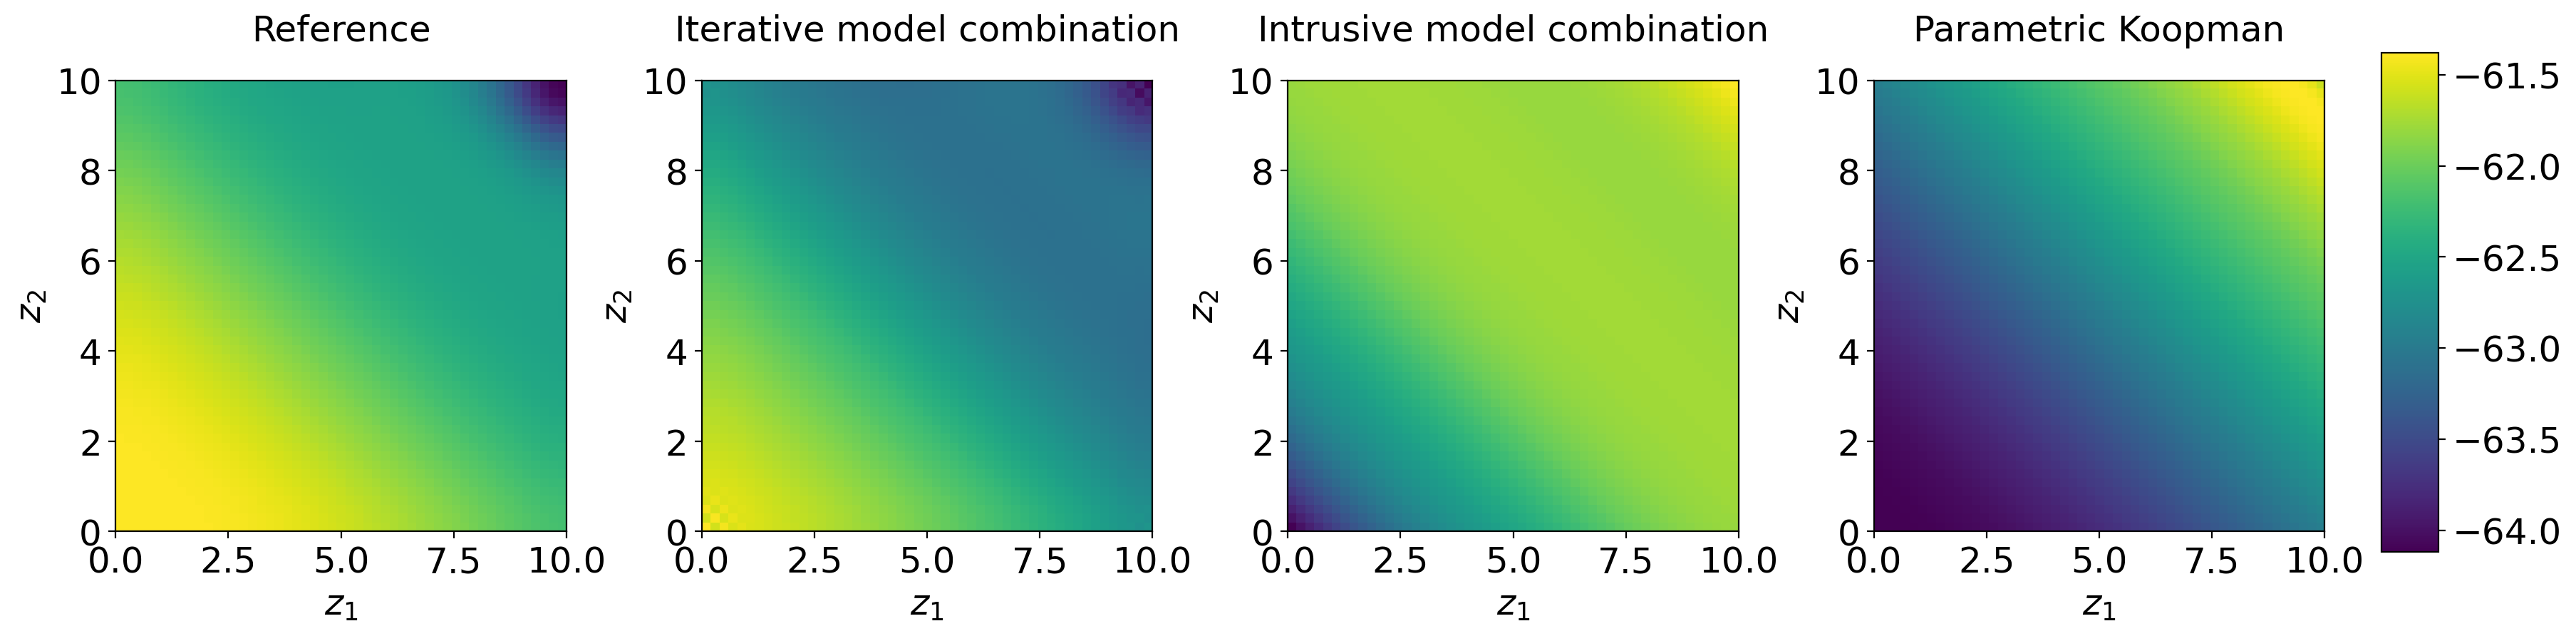

In [31]:
import numpy as np
import matplotlib.pyplot as plt
font_size = 18

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase horizontal and vertical space between subplots

# x_values = np.linspace(0, 10, 51)
# y_values = np.linspace(0, 10, 51)

titles = ['Reference', 'Iterative model combination', 'Intrusive model combination', 'Parametric Koopman']

# Create heatmaps for each subplot
for i, data in enumerate([multi_ref_reshape, multi_step_hybrid_reshape, multi_step_intrusive_reshape, multi_step_koopman_reshape]):
    im = axs[i].imshow(data[15,:,:,0], cmap='viridis', interpolation='nearest', extent=[0, 10, 0, 10])
    axs[i].set_xlabel('$z_1$', fontsize=font_size)
    axs[i].set_ylabel('$z_2$', fontsize=font_size)
    axs[i].set_title(titles[i], fontsize=font_size, pad=20)
    axs[i].tick_params(axis='both', labelsize=font_size)
    
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar_ax.tick_params(labelsize=font_size)
cbar = fig.colorbar(im, cax=cbar_ax)

plt.show()


In [32]:
index = 3

error_hybrid = np.abs(multi_ref_reshape[:16,:,:,index] - multi_step_hybrid_reshape[:16,:,:,index])
hybrid_relative_error = np.linalg.norm(error_hybrid)/np.linalg.norm(multi_ref_reshape[:16, :, :, index])
print(hybrid_relative_error)

error_koopman = np.abs(multi_ref_reshape[:16,:,:,index] - multi_step_koopman_reshape[:16,:,:,index])
koopman_relative_error = np.linalg.norm(error_koopman)/np.linalg.norm(multi_ref_reshape[:16,:,:,index])
print(koopman_relative_error)

error_residual = np.abs(multi_ref_reshape[:16,:,:,index] - multi_step_residual_reshape[:16,:,:,index])
residual_relative_error = np.linalg.norm(error_residual)/np.linalg.norm(multi_ref_reshape[:16,:,:,index])
print(residual_relative_error)

linear_array = np.tile(np.reshape(initial_data[:,index],(51,51)), (16, 1, 1))
error_linear = np.abs(linear_array - multi_ref_reshape[:16,:,:,index])
linear_relative_error = np.linalg.norm(error_linear)/np.linalg.norm(multi_ref_reshape[:16,:,:,index])
print(linear_relative_error)

error_intrusive = np.abs(multi_ref_reshape[:16,:,:,index] - multi_step_intrusive_reshape[:16,:,:,index])
intrusive_relative_error = np.linalg.norm(error_intrusive)/np.linalg.norm(multi_ref_reshape[:16,:,:,index])
print(intrusive_relative_error)

0.00246977856832087
0.01996396244973288
52961.70839253641
0.08236522282872293
0.09583958067066865


In [33]:
# Build the input tensor
DataModel = Cardiac_Electrophysiology_DataModel()
x1 = np.linspace(0,10,51)
t = np.linspace(0,10,50)
u_t = np.cos(t)
u_x_mesh = DataModel.dx(x1,x1)
u_test = u_t[:,np.newaxis,np.newaxis] * u_x_mesh[np.newaxis,:]

s_test = np.load('./data/s_test.npy')
v_test = np.load('./data/v_test.npy')
# Build v_data, s_data
v0 = v_test[0,:,:]
s0 = s_test[0,:,:,:]

m0 = np.reshape(s0[0,:,:],(-1,1))
n0 = np.reshape(s0[1,:,:],(-1,1))
h0 = np.reshape(s0[2,:,:],(-1,1))


initial_data = np.concatenate((np.reshape(v0,(-1,1)), m0, n0, h0), axis = 1)

u_data_test = np.reshape(u_test,(np.shape(u)[0],-1))

In [34]:
steps = 25
dlt_x = x1[1]-x1[0]
dim = 51

In [35]:
v_ref = v_test[0:steps+1]
v_ref = np.reshape(v_ref, (np.shape(v_ref)[0], -1, 1))
s_ref = s_test[0:steps+1,:,:,:]

m_ref = np.reshape(s_ref[:,0,:,:],(np.shape(v_ref)[0],-1,1))
n_ref = np.reshape(s_ref[:,1,:,:],(np.shape(v_ref)[0],-1,1))
h_ref = np.reshape(s_ref[:,2,:,:],(np.shape(v_ref)[0],-1,1))

ref_data = np.concatenate((v_ref, m_ref, n_ref, h_ref), axis = 2)

In [36]:
predict_results = model_Hybrid.Long_time_predict(initial_data, steps, dlt_x, dim, u_data_test)

In [37]:
Koopman_predicts = model_Koopman.Long_time_predict(initial_data, steps, u_data_test)

In [38]:
error_koopman = np.abs(ref_data - Koopman_predicts)

In [39]:
Intrusive_predicts = model_intrusive.long_time_predict(initial_data, steps, u_data_test, dlt_x)

In [40]:
Residual_predicts = model_residual.Long_time_predict(initial_data, steps, dlt_x, dim, u_data_test)

(15, 50)


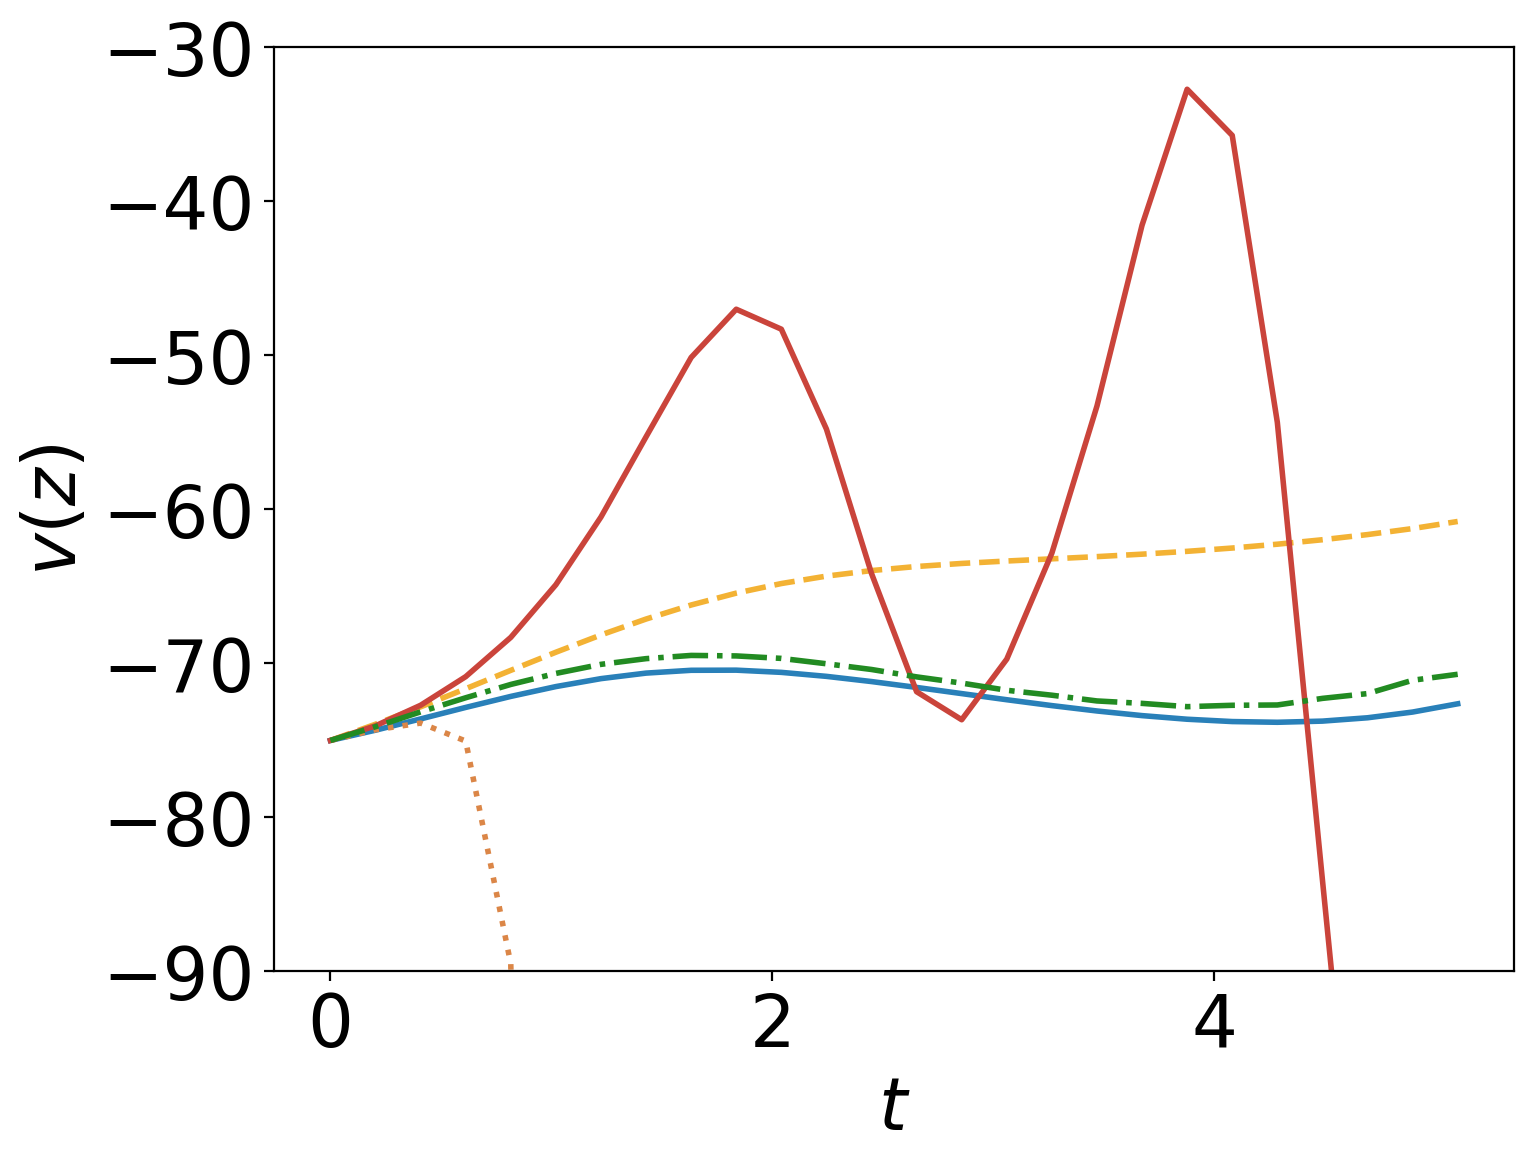

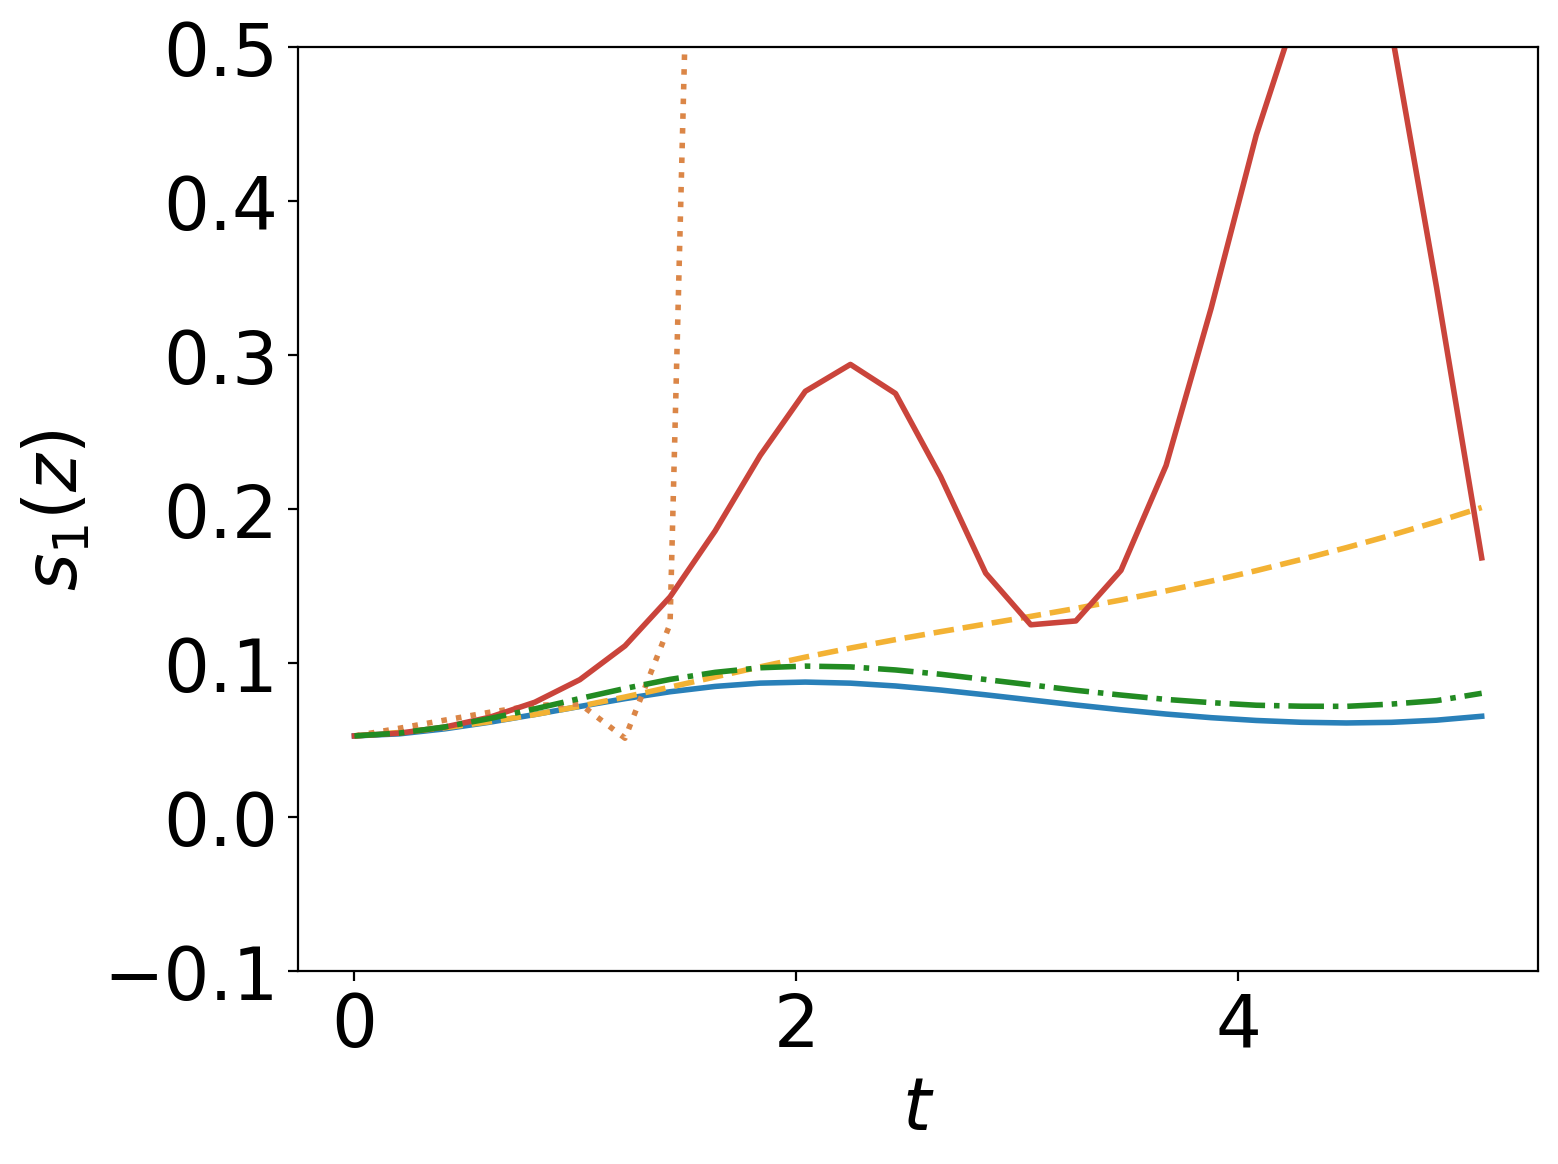

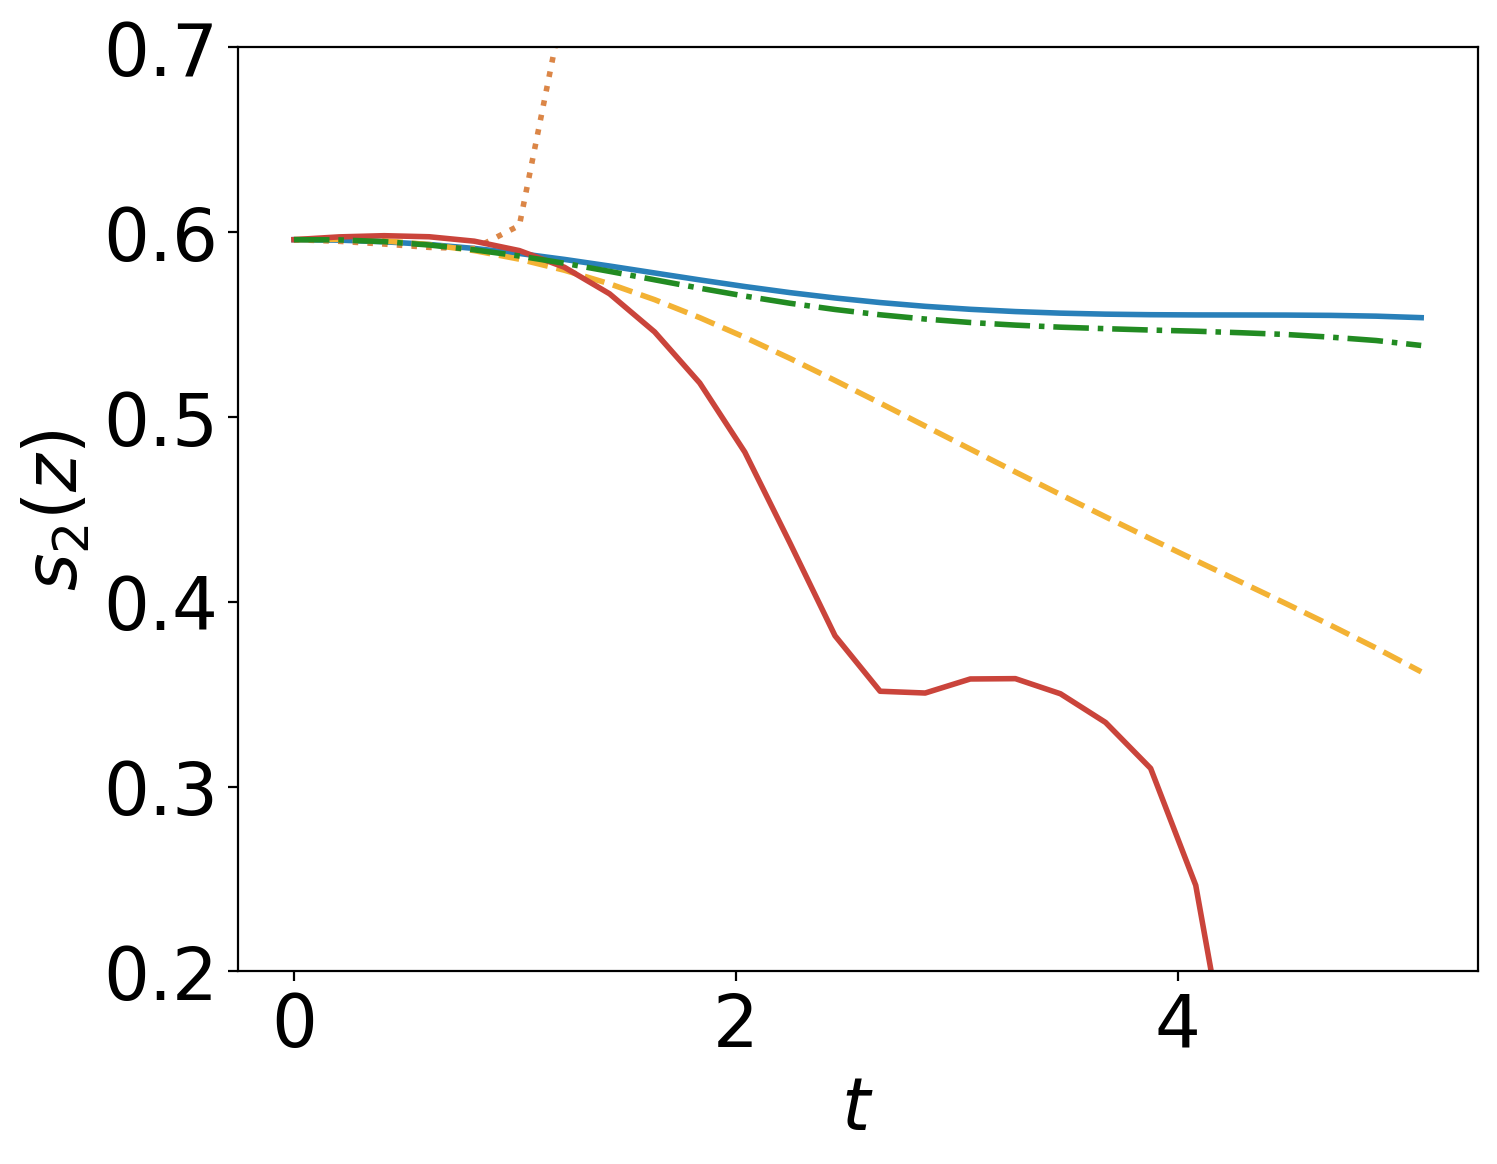

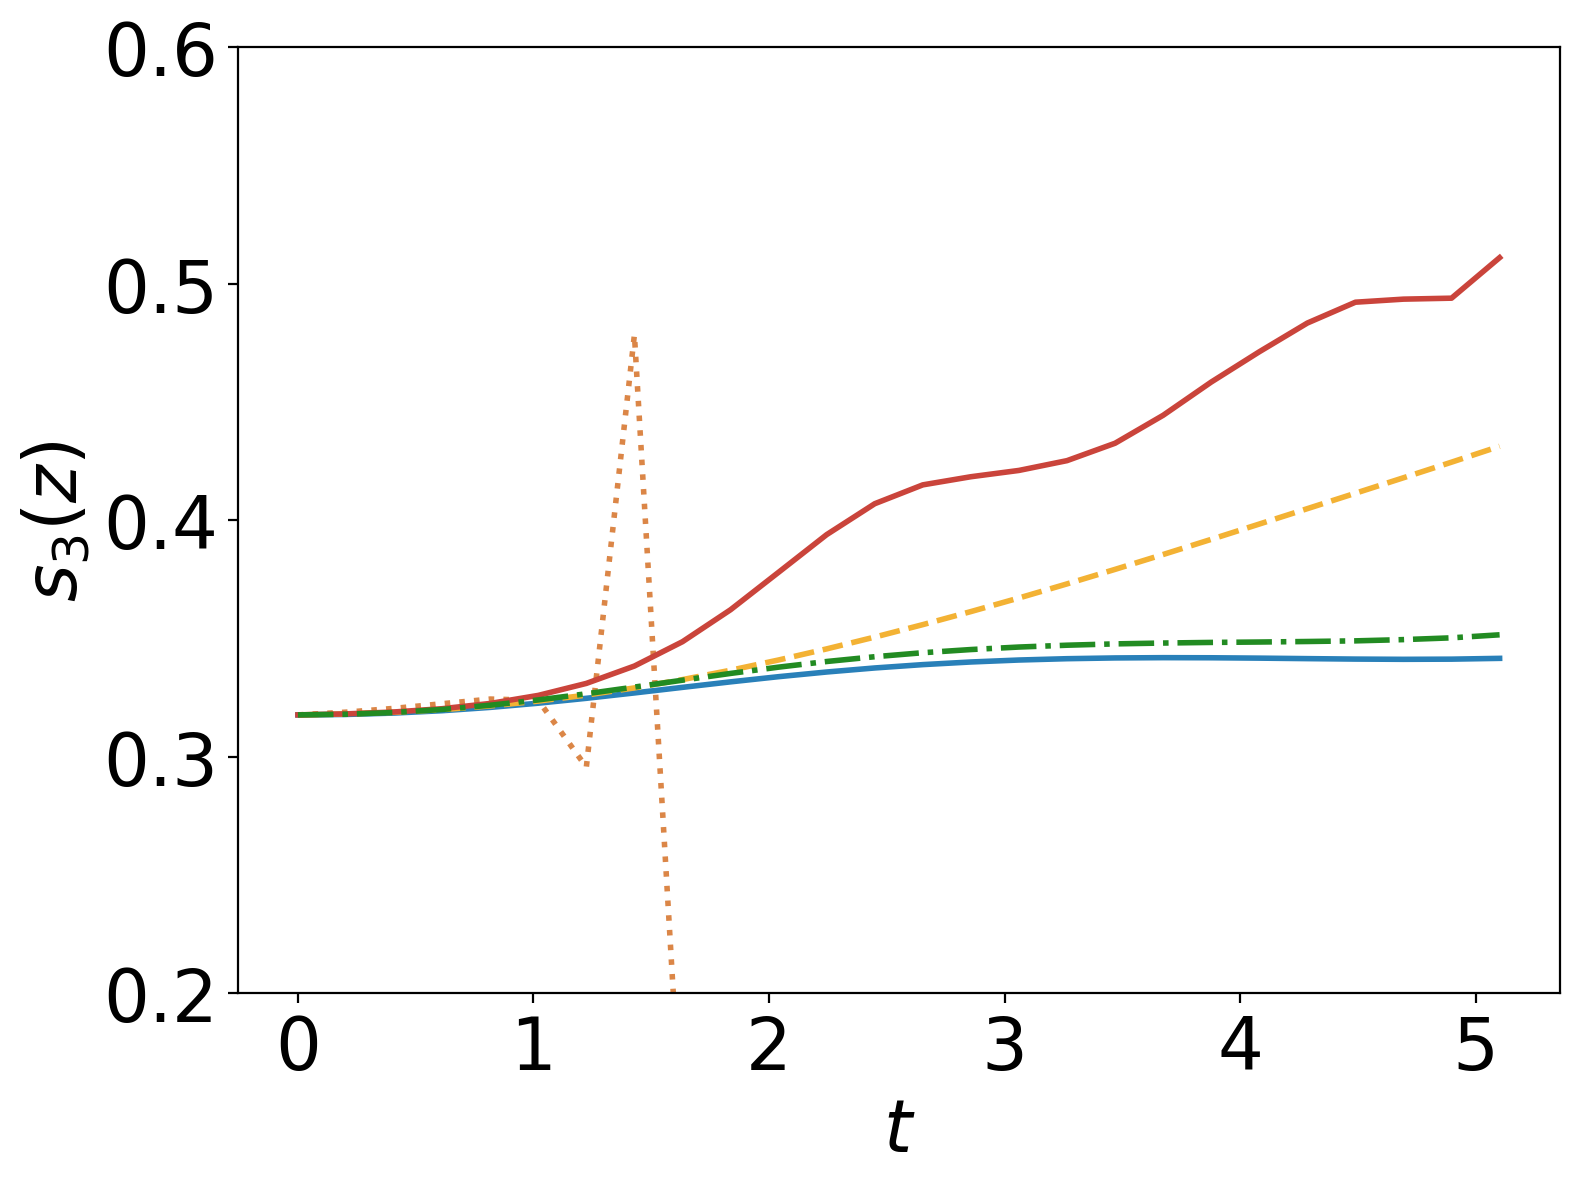

In [41]:
font_size = 26
line_width = 2.5
t_axis = t[:(steps+1)]

multi_step_hybrid_reshape = np.reshape(predict_results, (-1,51,51,4))
multi_step_koopman_reshape = np.reshape(Koopman_predicts, (-1,51,51,4))
multi_step_residual_reshape = np.reshape(Residual_predicts, (-1,51,51,4))
multi_step_intrusive_reshape = np.reshape(Intrusive_predicts, (-1,51,51,4))

multi_ref_reshape = np.reshape(ref_data, (-1,51,51,4))

# a_axis = np.random.randint(low = 0, high=51, size=None, dtype='l')
# b_axis = np.random.randint(low = 0, high=51, size=None, dtype='l')
a_axis, b_axis = 15,50
print((a_axis, b_axis))
line_width = 2

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,0],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,0], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,0], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')

plt.ylim(-90, -30)
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$v(z)$',fontsize=font_size)
plt.tick_params(labelsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,1],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,1], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,1], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_1(z)$',fontsize=font_size)
plt.ylim(-0.1, 0.5)

plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,2],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,2], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,2], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_2(z)$',fontsize=font_size)
plt.ylim(0.2, 0.7)

plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=font_size)
plt.show()

plt.figure(dpi=100,figsize=(8,6))
plt.plot(t_axis,multi_ref_reshape[:,a_axis,b_axis,3],color = color_dict_compare['ref'],linewidth = line_width, linestyle = '-', label = 'Reference')
plt.plot(t_axis,multi_step_koopman_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare1'],linewidth = line_width,linestyle = '--',label = 'Parametric Koopman')
plt.plot(t_axis,multi_step_residual_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare2'],linewidth = line_width,linestyle = ':',label = 'Residual Learning')
plt.plot(t_axis,multi_step_intrusive_reshape[:,a_axis,b_axis,3], color = color_dict_compare['compare3'],linewidth = line_width,linestyle = '-',label = 'Intrusive Model Combination')
plt.plot(t_axis,multi_step_hybrid_reshape[:,a_axis,b_axis,3], color = color_dict_compare['our'],linewidth = line_width,linestyle = '-.',label = 'Iterative Model Combination')
plt.xlabel('$t$',fontsize=font_size)
plt.ylabel('$s_3(z)$',fontsize=font_size)
plt.ylim(0.2, 0.6)
plt.tick_params(labelsize=font_size)
# plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

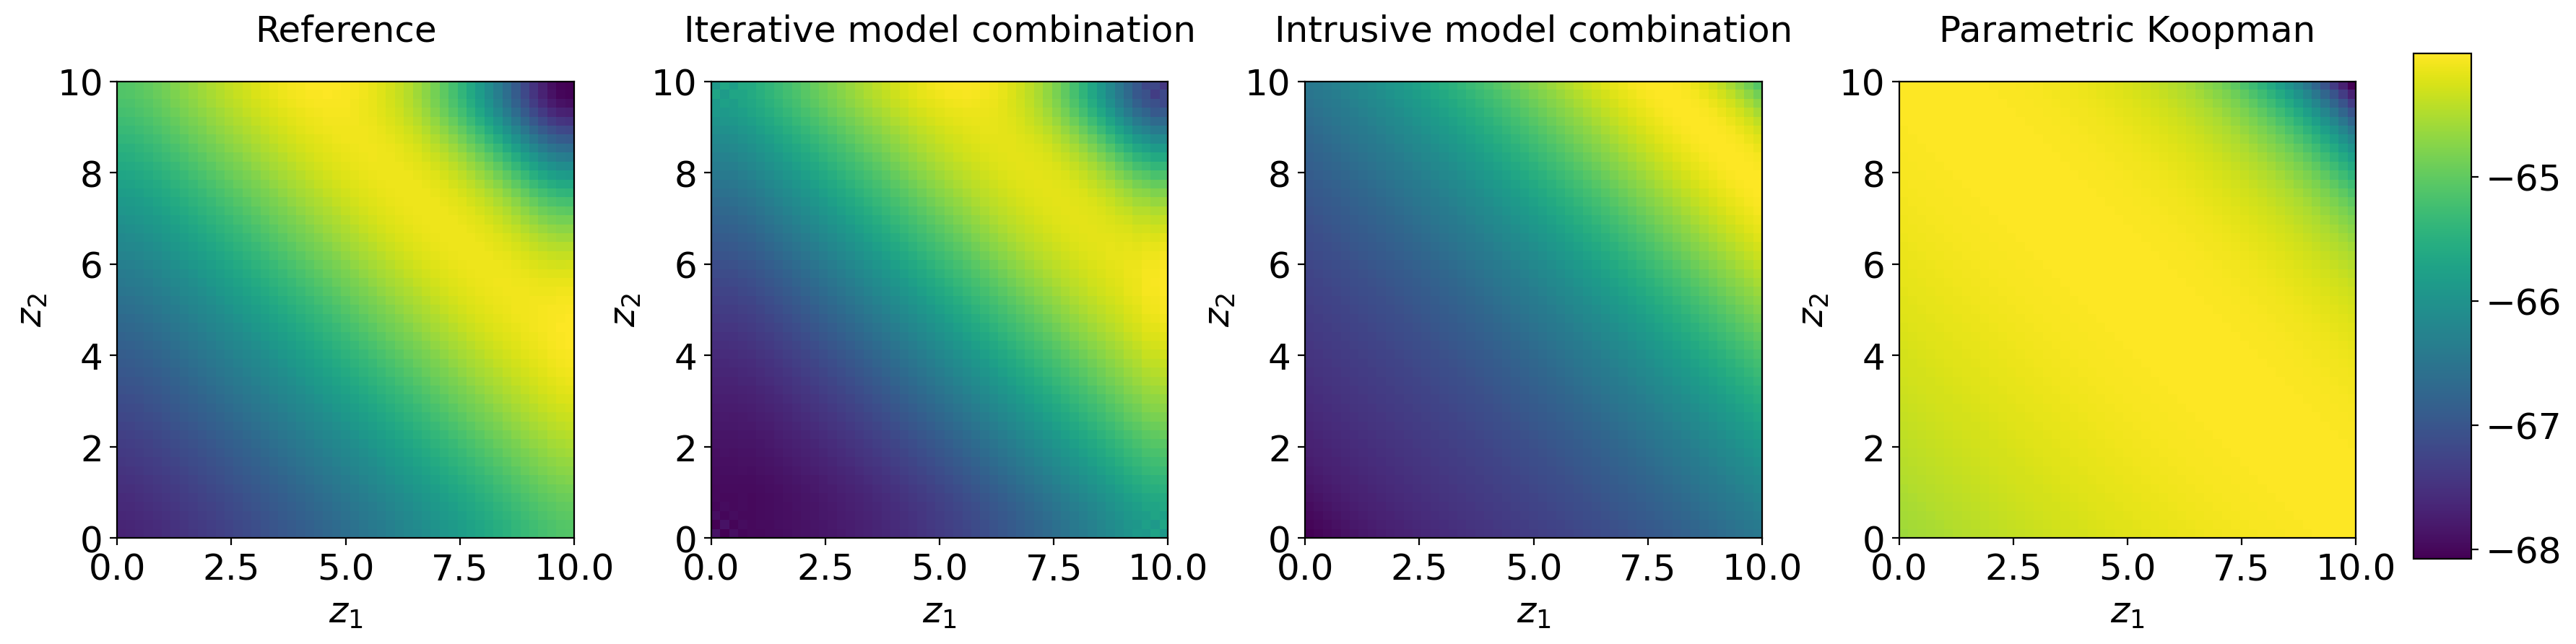

In [43]:
import numpy as np
import matplotlib.pyplot as plt
font_size = 18

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Increase horizontal and vertical space between subplots

# x_values = np.linspace(0, 10, 51)
# y_values = np.linspace(0, 10, 51)

titles = ['Reference', 'Iterative model combination', 'Intrusive model combination', 'Parametric Koopman']

# Create heatmaps for each subplot
for i, data in enumerate([multi_ref_reshape, multi_step_hybrid_reshape, multi_step_intrusive_reshape, multi_step_koopman_reshape]):
    im = axs[i].imshow(data[10,:,:,0], cmap='viridis', interpolation='nearest', extent=[0, 10, 0, 10])
    axs[i].set_xlabel('$z_1$', fontsize=font_size)
    axs[i].set_ylabel('$z_2$', fontsize=font_size)
    axs[i].set_title(titles[i], fontsize=font_size, pad=20)
    axs[i].tick_params(axis='both', labelsize=font_size)
    
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar_ax.tick_params(labelsize=font_size)
cbar = fig.colorbar(im, cax=cbar_ax)

plt.show()


In [48]:
index = 3

error_hybrid = np.abs(multi_ref_reshape[:11,:,:,index] - multi_step_hybrid_reshape[:11,:,:,index])
hybrid_relative_error = np.linalg.norm(error_hybrid)/np.linalg.norm(multi_ref_reshape[:11, :, :, index])
print(hybrid_relative_error)

error_koopman = np.abs(multi_ref_reshape[:11,:,:,index] - multi_step_koopman_reshape[:11,:,:,index])
koopman_relative_error = np.linalg.norm(error_koopman)/np.linalg.norm(multi_ref_reshape[:11,:,:,index])
print(koopman_relative_error)

error_residual = np.abs(multi_ref_reshape[:11,:,:,index] - multi_step_residual_reshape[:11,:,:,index])
residual_relative_error = np.linalg.norm(error_residual)/np.linalg.norm(multi_ref_reshape[:11,:,:,index])
print(residual_relative_error)

linear_array = np.tile(np.reshape(initial_data[:,index],(51,51)), (11, 1, 1))
error_linear = np.abs(linear_array - multi_ref_reshape[:11,:,:,index])
linear_relative_error = np.linalg.norm(error_linear)/np.linalg.norm(multi_ref_reshape[:11,:,:,index])
print(linear_relative_error)

error_intrusive = np.abs(multi_ref_reshape[:11,:,:,index] - multi_step_intrusive_reshape[:11,:,:,index])
intrusive_relative_error = np.linalg.norm(error_intrusive)/np.linalg.norm(multi_ref_reshape[:11,:,:,index])
print(intrusive_relative_error)

0.008849923552814108
0.013653724983385873
11.621340223064692
0.06007620768280039
0.0939891011859305
